__Import libraries__

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

__Import Data__

In [ ]:
features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv',parse_dates=[1])
stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv',parse_dates=[2])
train = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv',parse_dates=[2])

__Merge data into 1 DataFrame__

In [3]:
train_data = pd.merge(left=pd.merge(left=train,right=stores,how='left'),right=features,how='left',on=['Store','Date','IsHoliday'])
test_data = pd.merge(left = pd.merge(left=test,right=stores,how='left'),right=features,how='left',on = ['Store','Date','IsHoliday'])

__Add Features__

In [4]:
train_data['CPI_cat'] = np.where(train_data.CPI<160,'LowCPI','HighCPI')
test_data['CPI_cat'] = np.where(test_data.CPI<160,'LowCPI','HighCPI')

train_data['Size_cat'] = np.where(train_data.Size<75000,'Small_Size',np.where(train_data.Size<175000,'Mid_Size','High_Size'))
test_data['Size_cat'] = np.where(test_data.Size<75000,'Small_Size',np.where(test_data.Size<175000,'Mid_Size','High_Size'))

In [5]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])



train_data['Which_Holiday'] = 'NoHoliday'
train_data.loc[(np.isin(train_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
train_data.loc[(np.isin(train_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
train_data.loc[(np.isin(train_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
train_data.loc[(np.isin(train_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'

test_data['Which_Holiday'] = 'NoHoliday'
test_data.loc[(np.isin(test_data[['Date']].values, sb_dates.values).reshape(-1)),'Which_Holiday'] = 'Super_Bowl'
test_data.loc[(np.isin(test_data[['Date']].values, labor_dates.values).reshape(-1)),'Which_Holiday'] = 'Labor_Day'
test_data.loc[(np.isin(test_data[['Date']].values, thanksgiving_dates.values).reshape(-1)),'Which_Holiday'] = 'Thanksgiving'
test_data.loc[(np.isin(test_data[['Date']].values, christmas_dates.values).reshape(-1)),'Which_Holiday'] = 'Christmas'


In [6]:
from math import ceil

def create_date_features(df):
    
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    #df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
  
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['Date'].apply(week_of_month)
    
    return df


__Create data for log scaled target__

In [7]:
train_log = train_data[train_data.Weekly_Sales>0]
train_log.loc[:,'Weekly_Sales_log'] = np.log(train_log.Weekly_Sales)

C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


__Seperate targets__

In [8]:
weekly_sales = train_data.Weekly_Sales
weekly_sales_log = train_log.Weekly_Sales_log
weekly_sales_log_org = train_log.Weekly_Sales

train_data.drop('Weekly_Sales',axis=1,inplace=True)
train_log.drop(['Weekly_Sales_log','Weekly_Sales'],axis=1,inplace=True)


C:\Users\shahb\AnacondaPython\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
sb_dates = pd.to_datetime(['2010-02-12','2011-02-11','2012-02-10','2013-02-08'])
labor_dates = pd.to_datetime(['2010-09-10','2011-09-09','2012-09-07','2013-09-06'])
thanksgiving_dates = pd.to_datetime(['2010-11-26','2011-11-25','2012-11-23','2013-11-29'])
christmas_dates = pd.to_datetime(['2010-12-31','2011-12-30','2012-12-28','2013-12-27'])

holiday_dates = sb_dates.append(labor_dates).append(thanksgiving_dates).append(christmas_dates)

In [10]:
train_data['WeeksTillNextHoliday'] = train_data.Date.apply(lambda x: min([diff for diff in (x-holiday_dates).days if diff>=0],default=-1)//7)
train_data['WeeksSinceLastHoliday'] = train_data.Date.apply(lambda x: abs(max([diff for diff in (x-holiday_dates).days if diff<=0],default=-1)//7))


train_data['WeeksTillNextSuperBowl'] = train_data.Date.apply(lambda x: min([diff for diff in (x-sb_dates).days if diff>=0],default=-1)//7)
train_data['WeeksSinceLastSuperBowl'] = train_data.Date.apply(lambda x: abs(max([diff for diff in (x-sb_dates).days if diff<=0],default=-1)//7))


train_data['WeeksTillLaborDay'] = train_data.Date.apply(lambda x: min([diff for diff in (x-labor_dates).days if diff>=0],default=-1)//7)
train_data['WeeksSinceLastLaborDay'] = train_data.Date.apply(lambda x: abs(max([diff for diff in (x-labor_dates).days if diff<=0],default=-1)//7))

train_data['WeeksTillNextThanksgiving'] = train_data.Date.apply(lambda x: min([diff for diff in (x-thanksgiving_dates).days if diff>=0],default=-1)//7)
train_data['WeeksSinceLastThanksgiving'] = train_data.Date.apply(lambda x: abs(max([diff for diff in (x-thanksgiving_dates).days if diff<=0],default=-1)//7))

train_data['WeeksTillNextChristmas'] = train_data.Date.apply(lambda x: min([diff for diff in (x-christmas_dates).days if diff>=0],default=-1)//7)
train_data['WeeksSinceLastChristmas'] = train_data.Date.apply(lambda x: abs(max([diff for diff in (x-christmas_dates).days if diff<=0],default=-1)//7))


In [11]:
test_data['WeeksTillNextHoliday'] = test_data.Date.apply(lambda x: min([diff for diff in (x-holiday_dates).days if diff>=0],default=-1)//7)
test_data['WeeksSinceLastHoliday'] = test_data.Date.apply(lambda x: abs(max([diff for diff in (x-holiday_dates).days if diff<=0],default=-1)//7))


test_data['WeeksTillNextSuperBowl'] = test_data.Date.apply(lambda x: min([diff for diff in (x-sb_dates).days if diff>=0],default=-1)//7)
test_data['WeeksSinceLastSuperBowl'] = test_data.Date.apply(lambda x: abs(max([diff for diff in (x-sb_dates).days if diff<=0],default=-1)//7))


test_data['WeeksTillLaborDay'] = test_data.Date.apply(lambda x: min([diff for diff in (x-labor_dates).days if diff>=0],default=-1)//7)
test_data['WeeksSinceLastLaborDay'] = test_data.Date.apply(lambda x: abs(max([diff for diff in (x-labor_dates).days if diff<=0],default=-1)//7))

test_data['WeeksTillNextThanksgiving'] = test_data.Date.apply(lambda x: min([diff for diff in (x-thanksgiving_dates).days if diff>=0],default=-1)//7)
test_data['WeeksSinceLastThanksgiving'] = test_data.Date.apply(lambda x: abs(max([diff for diff in (x-thanksgiving_dates).days if diff<=0],default=-1)//7))

test_data['WeeksTillNextChristmas'] = test_data.Date.apply(lambda x: min([diff for diff in (x-christmas_dates).days if diff>=0],default=-1)//7)
test_data['WeeksSinceLastChristmas'] = test_data.Date.apply(lambda x: abs(max([diff for diff in (x-christmas_dates).days if diff<=0],default=-1)//7))


__Preprocessing__

In [13]:
num_features = train_data.columns[np.isin(train_data.dtypes,['int64','float64'])]
cat_features = train_data.columns[train_data.dtypes=='object']


In [14]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [15]:
train_data,test_data = one_hot_encoding(train_data,test_data,cat_features)

In [16]:
def imputing(train,test,num_features):
    imputer = SimpleImputer(strategy='constant',fill_value=0)

    imp_train = pd.DataFrame(imputer.fit_transform(train[num_features]),columns=num_features)
    train[num_features] = imp_train
    
    imp_test = pd.DataFrame(imputer.transform(test[num_features]),columns=num_features)
    test[num_features] = imp_test
    
    return train,test

In [17]:
train_data,test_data = imputing(train_data,test_data,num_features)


In [18]:
X = create_date_features(train_data)

In [19]:
def custom_loss_scorer(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(y-preds))
    
    return error

In [20]:
X.drop("Date",axis=1,inplace=True)

In [104]:
xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 n_jobs=-1,
 seed=27)

In [105]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test1,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 143.2min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:32:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 9817.907
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 1000, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': None, 'subsample': 0.8, 'verbosity': 1}


max_depth =3
min_child_weight=5

In [116]:
pd.DataFrame(grid_search.cv_results_)

C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,705.817259,328.727606,4.636652,0.195798,3,1,"{'max_depth': 3, 'min_child_weight': 1}",11273.208650,9963.959923,9813.500880,7924.640145,9743.827400,1193.918129,3,4652.144178,5984.793375,6223.854614,6265.233723,5781.506473,660.766352
1,705.161476,328.177453,4.745396,0.414917,3,3,"{'max_depth': 3, 'min_child_weight': 3}",11212.559172,9791.262578,9733.361919,7884.353515,9655.384296,1181.724062,7,4644.720024,6054.020336,6276.744849,6290.500457,5816.496416,683.005486
2,727.781154,347.942669,4.906384,0.764734,3,5,"{'max_depth': 3, 'min_child_weight': 5}",11240.764966,10202.638396,9758.635619,8069.590442,9817.907356,1143.751166,1,4649.662270,6084.516541,6283.485718,6352.993032,5842.664390,695.791867
3,1061.704652,503.486372,9.084218,0.807034,5,1,"{'max_depth': 5, 'min_child_weight': 1}",10640.109528,10413.931874,10350.196599,6978.234372,9595.618094,1514.982349,11,2125.915108,3013.650885,3596.839461,3717.888697,3113.573538,629.324335
4,1066.868855,509.756812,8.838124,0.546188,5,3,"{'max_depth': 5, 'min_child_weight': 3}",10646.839873,10769.383722,10287.353596,6982.432016,9671.502302,1562.609901,6,2196.265845,3100.224892,3591.941167,3821.038898,3177.367700,623.437173
5,1071.925571,511.030150,9.003573,0.656985,5,5,"{'max_depth': 5, 'min_child_weight': 5}",10552.565131,10889.092899,10508.802458,7018.823101,9742.320897,1579.281163,4,2212.782577,3175.993369,3670.352295,3830.800741,3222.482245,630.930584
6,1460.935988,711.564861,29.835277,2.099301,7,1,"{'max_depth': 7, 'min_child_weight': 1}",10620.474528,10316.283977,10453.067440,7008.904214,9599.682540,1499.660964,10,1156.553566,1670.350613,2005.314133,2137.177386,1742.348925,378.609355
7,1461.056103,713.609648,30.846287,1.881078,7,3,"{'max_depth': 7, 'min_child_weight': 3}",10760.966972,10300.410745,10378.156598,6888.674176,9582.052123,1564.764074,12,1206.186068,1753.494957,2077.291953,2200.753548,1809.431631,384.680424
8,1452.591534,701.385998,27.629635,1.579049,7,5,"{'max_depth': 7, 'min_child_weight': 5}",10800.420115,10604.778687,10252.870996,6889.343495,9636.853323,1598.362851,9,1272.777156,1830.277039,2130.362167,2273.353938,1876.692575,383.587257
9,1835.782858,845.434449,56.059184,16.919208,9,1,"{'max_depth': 9, 'min_child_weight': 1}",10799.096891,10730.956095,10337.894805,6700.184252,9642.033011,1707.574893,8,609.906710,946.298391,1152.361398,1241.007098,987.393399,242.754685


In [107]:
from xgboost import plot_importance

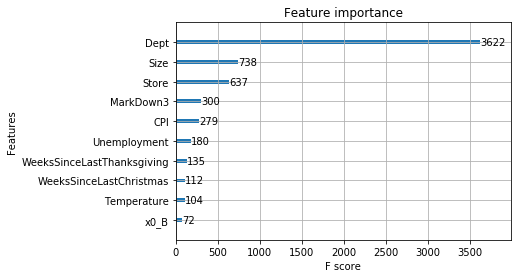

In [135]:
plot_importance(grid_search.best_estimator_,max_num_features=10)

In [134]:
?plot_importance

In [112]:
all_test_preds = grid_search.best_estimator_.predict(test_data)
train_preds = grid_search.best_estimator_.predict(train_data)

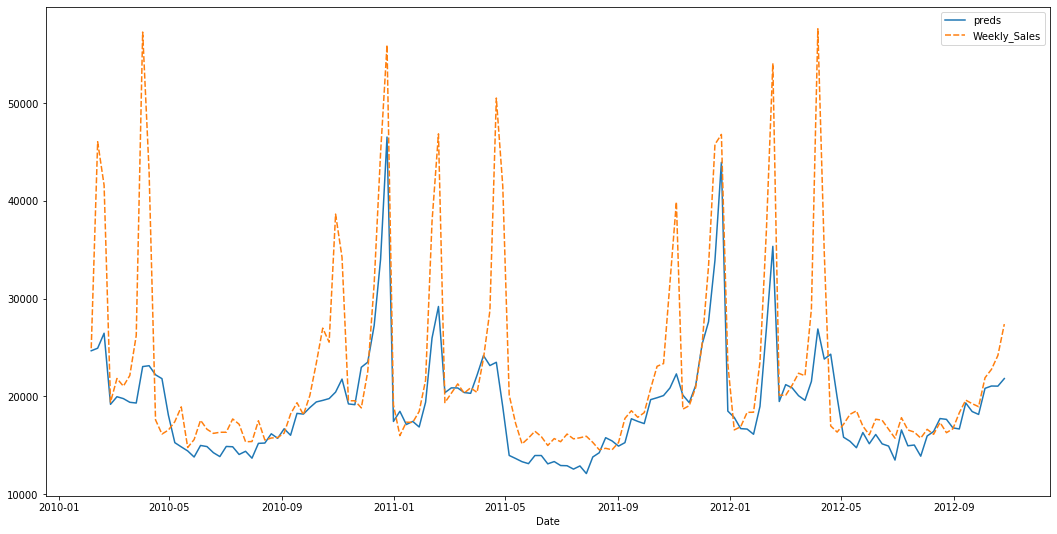

In [114]:
train_copy = train_data.copy()
train_copy['preds'] = train_preds
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = train['Weekly_Sales']
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==1)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])

In [119]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test4,
                           scoring=custom_loss_scorer,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X,weekly_sales)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 119.6min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 303.7min finished


[17:40:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 9975.978
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 1000, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.7, 'verbosity': 1}


In [185]:
pd.DataFrame(grid_search.cv_results_)

C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shahb\AnacondaPython\lib\site-p

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,98.784667,40.225988,0.488937,0.122457,0.7,0.9,"{'colsample_bytree': 0.7, 'subsample': 0.9}",inf,inf,inf,inf,inf,NaN,1,inf,inf,inf,inf,inf,NaN


C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
C:\Users\shahb\AnacondaPython\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


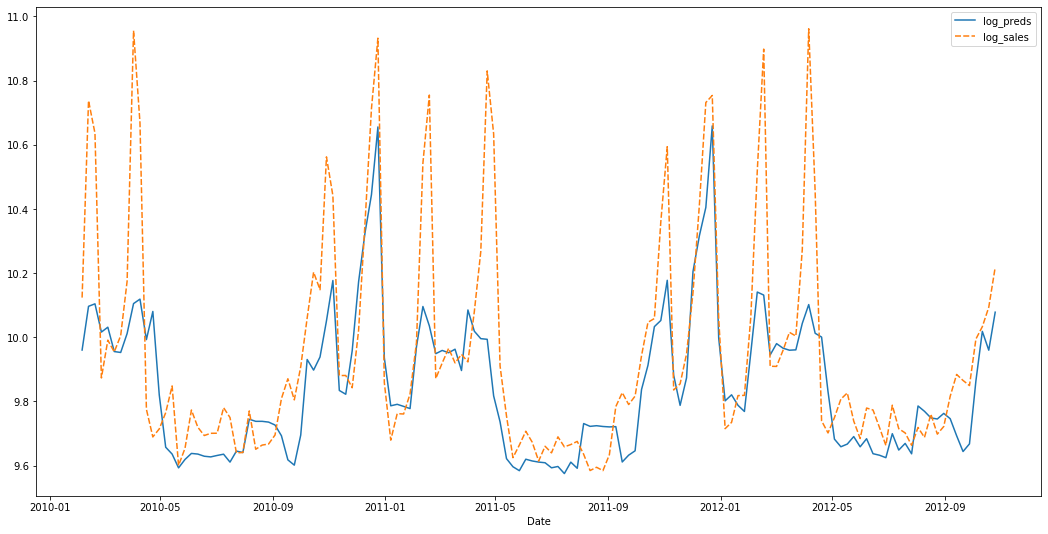

In [183]:
all_test_preds = grid_search.best_estimator_.predict(test_data[imp_features])
train_preds = grid_search.best_estimator_.predict(train_data[imp_features])
train_copy = train_data.copy()
train_copy['preds'] = train_preds
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = train['Weekly_Sales']
train_copy['log_sales'] = np.log(train_copy.Weekly_Sales)
train_copy['log_preds'] = np.log(train_copy.preds)
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==1)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['log_preds','log_sales']])

In [137]:
grid_search.best_params_

{'colsample_bytree': 0.9, 'subsample': 0.7}

In [166]:
imp_features = []
c=0
for j in iter(grid_search.best_estimator_.get_booster().get_score()):
    imp_features.append(j)
    c+=1
    if c==10:
        break

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [167]:
imp_features = ['Dept','Size','Store','Markdown3','CPI']

In [168]:
X[imp_features].head()

,IsHoliday
0,False
1,True
2,False
3,False
4,False


In [192]:
reduced_X = X[imp_features]
len(reduced_X)
pos_weekly_sales_ind = weekly_sales>0
len(reduced_X[pos_weekly_sales_ind])

420212

In [200]:
param_test4 = {
 'subsample':[0.9],
 'colsample_bytree':[0.7]
}

xgb_reg = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=5,
 gamma=0,
 n_jobs=-1)

grid_search = GridSearchCV(estimator=xgb_reg,
                           param_grid=param_test4,
                           scoring=custom_loss_scorer_log,
                           cv=TimeSeriesSplit(n_splits=4),
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(reduced_X[pos_weekly_sales_ind],np.log(weekly_sales[pos_weekly_sales_ind]))
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print(best_parameters)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.5min finished
C:\Users\shahb\AnacondaPython\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 9045.509
Best parameters set:
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 5, 'missing': None, 'n_estimators': 1000, 'n_jobs': -1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.9, 'verbosity': 1}


In [201]:
def custom_loss_scorer_log(estimator,X,y):
    weight_array = np.where(X.IsHoliday==True,5,1)
    preds = estimator.predict(X)
    error = np.mean(weight_array*np.abs(np.exp(y)-np.exp(preds)))
    
    return error

#weight = reduced_X[pos_weekly_sales_ind].IsHoliday==True,5,1
custom_loss_scorer_log(grid_search.best_estimator_,reduced_X[pos_weekly_sales_ind],np.log(weekly_sales[pos_weekly_sales_ind]))

5742.813827709337

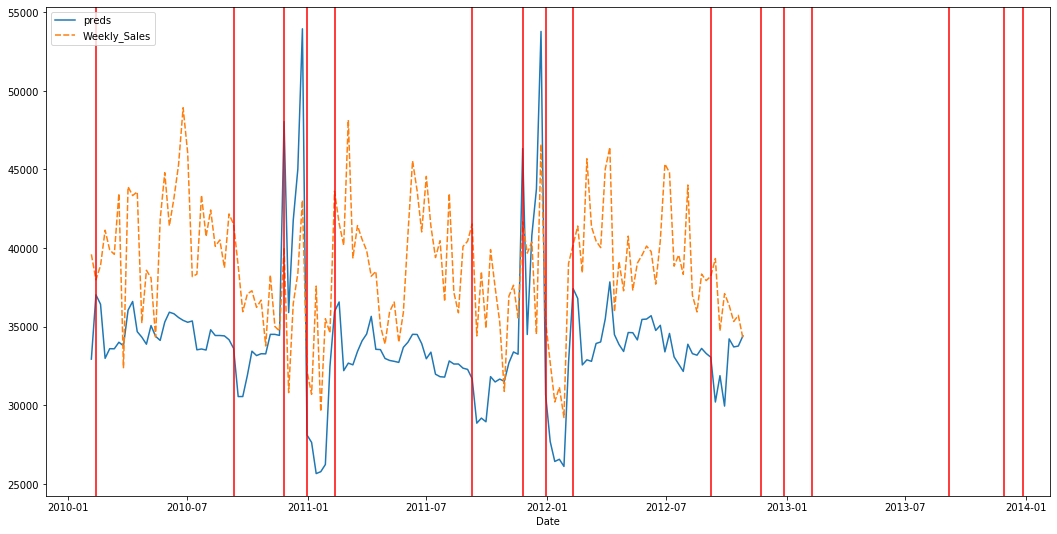

In [218]:
all_test_preds = grid_search.best_estimator_.predict(test_data[imp_features])
train_preds = grid_search.best_estimator_.predict(train_data[imp_features])
train_copy = train_data.copy()
train_copy['preds'] = np.exp(train_preds)
train_copy['Date'] = train['Date']
train_copy['Weekly_Sales'] = weekly_sales[pos_weekly_sales_ind]
t_1_1 = train_copy[(train_copy.Store==2) & (train_copy.Dept==10)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])
for i in range(len(holiday_dates)):
    plt.axvline(holiday_dates[i],color='red')

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,x3_NoHoliday,x3_Super_Bowl,x3_Thanksgiving,quarter,month,year,weekofyear,weekofmonth,preds,Weekly_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1.0,3.0,False,151315.0,42.31,2.572,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,2,2010,5,1,11869.894531,13740.12
2010-02-12,1.0,3.0,True,151315.0,38.51,2.548,0.00,0.00,0.00,0.00,...,0.0,1.0,0.0,1,2,2010,6,2,13169.773438,10887.84
2010-02-19,1.0,3.0,False,151315.0,39.93,2.514,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,2,2010,7,3,12956.275391,11523.47
2010-02-26,1.0,3.0,False,151315.0,46.63,2.561,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,2,2010,8,4,11235.372070,11135.17
2010-03-05,1.0,3.0,False,151315.0,46.50,2.625,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,3,2010,9,1,11444.248047,12275.58
2010-03-12,1.0,3.0,False,151315.0,57.79,2.667,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,3,2010,10,2,11282.541016,10123.45
2010-03-19,1.0,3.0,False,151315.0,54.58,2.720,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,3,2010,11,3,11422.658203,9001.37
2010-03-26,1.0,3.0,False,151315.0,51.45,2.732,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,1,3,2010,12,4,11298.574219,10366.85
2010-04-02,1.0,3.0,False,151315.0,62.27,2.719,0.00,0.00,0.00,0.00,...,1.0,0.0,0.0,2,4,2010,13,1,11676.533203,11157.08


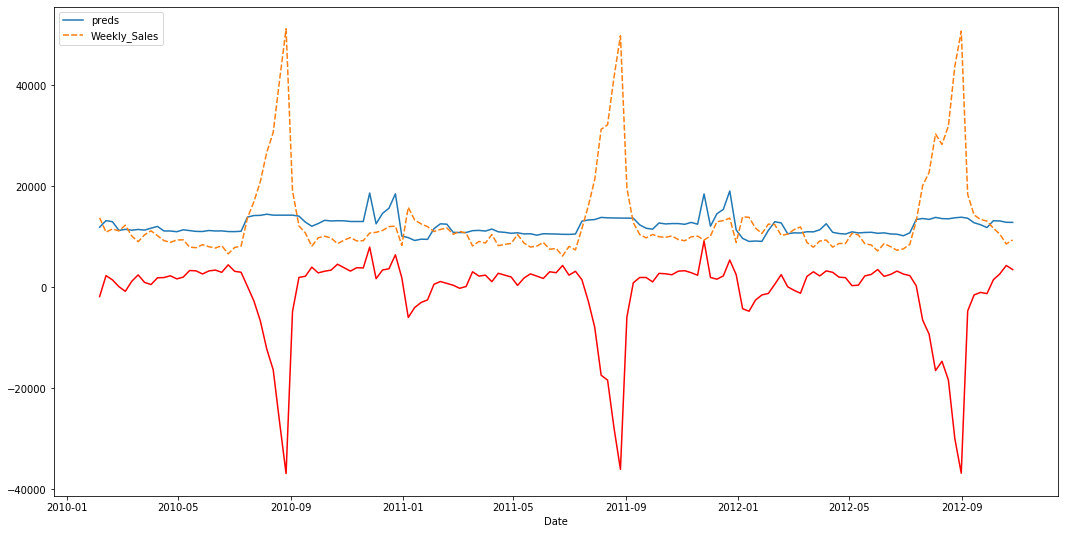

In [230]:
t_1_1 = train_copy[(train_copy.Store==1) & (train_copy.Dept==3)]
t_1_1.set_index('Date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1.preds-t_1_1.Weekly_Sales,color='red')
sns.lineplot(data=t_1_1[['preds','Weekly_Sales']])
t_1_1

In [206]:
test_output = test_data.copy()
test_output['preds'] = np.exp(all_test_preds)
test_output['id'] = test_output['Store'].astype(int).astype(str) + '_' +  test_output['Dept'].astype(int).astype(str) + '_' +  test['Date'].astype(str)
test_output = test_output[['id', 'preds']]
test_output = test_output.rename(columns={'id': 'Id', 'preds': 'Weekly_Sales'})

test_output.to_csv('output.csv', index=False)

In [207]:
test_output.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,23114.003906
1,1_1_2012-11-09,19001.152344
2,1_1_2012-11-16,19944.662109
3,1_1_2012-11-23,24940.197266
4,1_1_2012-11-30,23125.115234
